In [1]:
import torch
import numpy as np
from preprocessing.data_pipeline import build_data_pipeline

from preprocessing.preprocess_ucr import UCRDatasetImporter
from pathlib import Path

from models.stage2.sample import unconditional_sample, conditional_sample

# from evaluation.evaluation import Evaluation
from utils import get_root_dir, load_yaml_param_settings, save_model
from models.stage2.maskgit import MaskGIT
import os
import tempfile
from evaluation.model_eval import Evaluation
import matplotlib.pyplot as plt


/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_dir = "configs/config.yaml"
config = load_yaml_param_settings(config_dir)
dataset_name = config["dataset"]["dataset_name"]

dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage2"]
train_data_loader, test_data_loader = [
    build_data_pipeline(batch_size, dataset_importer, config, kind)
    for kind in ["train", "test"]
]

input_length = train_data_loader.dataset.X.shape[-1]
n_classes = len(np.unique(train_data_loader.dataset.Y.flatten()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


self.X_train.shape: (1000, 1024)
self.X_test.shape: (8236, 1024)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]


/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:

eval = Evaluation(dataset_name, device, config, batch_size=batch_size)

self.X_train.shape: (1000, 1024)
self.X_test.shape: (8236, 1024)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]


In [6]:
n_samples = len(test_data_loader.dataset.X)
#x_gen = eval.sample(n_samples, input_length, n_classes, 'unconditional')
x_gen = eval.sampleMaskGit(n_samples, input_length, n_classes, "unconditional")

1
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
encoder-StarLightCurves.ckpt
 encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
decoder-StarLightCurves.ckpt
 decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vqmodel-StarLightCurves.ckpt
 vqmodel loaded


100%|██████████| 65/65 [01:04<00:00,  1.00it/s]


In [5]:
x_gen_mage = eval.sampleMAGE(n_samples, input_length, n_classes, "unconditional")

1
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
encoder-StarLightCurves.ckpt
 encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
decoder-StarLightCurves.ckpt
 decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vqmodel-StarLightCurves.ckpt
 vqmodel loaded


100%|██████████| 65/65 [01:22<00:00,  1.27s/it]


In [7]:
n_figs = 100
def plot_samples(x_gen, n_figs=100, title=""):
    for i in np.random.choice(len(x_gen), n_figs): plt.plot(x_gen[i, 0, :], alpha=0.5)
    plt.title(title)
    plt.show()


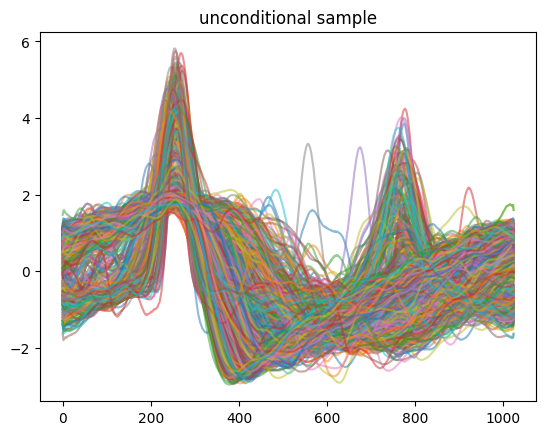

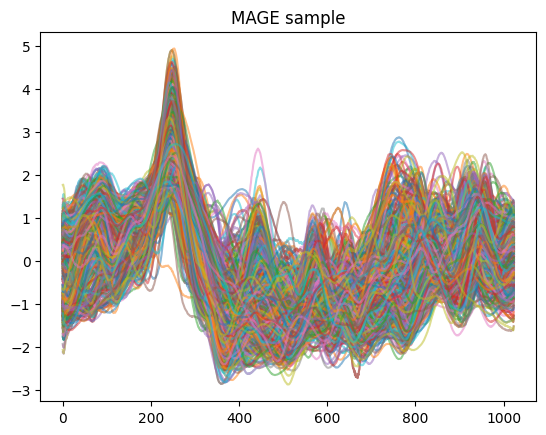

In [9]:
plot_samples(x_gen, n_figs=1000, title="unconditional sample")
plot_samples(x_gen_mage, n_figs=1000, title="MAGE sample")

In [10]:
z_test, z_gen = eval.compute_z(x_gen)
z_test_mage, z_gen_mage = eval.compute_z(x_gen_mage)

In [12]:
fid, _ = eval.fid_score(z_test, z_gen)
fid_mage = eval.fid_score(z_test_mage, z_gen_mage)
IS_mean, IS_std = eval.inception_score(x_gen)
IS_mean_mage, IS_std_mage = eval.inception_score(x_gen_mage)

#wandb.log({'FID': fid, 'IS_mean': IS_mean, 'IS_std': IS_std})

#eval.visual_inspection(min(200, eval.X_test.shape[0]), x_gen, log=False)
#eval.pca(min(1000, eval.X_test.shape[0]), x_gen, z_test, z_gen, log=False)
#eval.tsne(min(1000, eval.X_test.shape[0]), x_gen, z_test, z_gen, log=False)

In [13]:
print("fid", fid)
print("IS_mean", IS_mean)
print("IS_std", IS_std)

print("fid mage", fid_mage)
print("IS_mean mage", IS_mean_mage)
print("IS_std mage", IS_std_mage)


fid 3.1026366899274658
IS_mean 1.959811
IS_std 0.040134486
fid mage (14.559390312396093, (array([[0.55614537, 0.32928318, 0.6039561 , ..., 0.41543922, 0.6451398 ,
        0.42450607],
       [0.6382011 , 0.82166225, 0.6896222 , ..., 0.59843445, 0.67121756,
        0.57526433],
       [0.80187947, 0.535758  , 0.84484184, ..., 0.7787291 , 0.8046337 ,
        0.7409374 ],
       ...,
       [0.18292396, 0.75999546, 0.1898126 , ..., 0.17140505, 0.1880753 ,
        0.17043236],
       [0.5692598 , 0.61502975, 0.55462795, ..., 0.5071802 , 0.61626273,
        0.4900986 ],
       [0.8575362 , 0.95649993, 0.8979809 , ..., 0.8022408 , 0.84327364,
        0.79304326]], dtype=float32), array([[0.89378715, 0.83165604, 0.956003  , ..., 0.92376065, 0.89688593,
        0.88464135],
       [0.83899784, 0.6661192 , 0.7914495 , ..., 0.8476958 , 0.96884894,
        0.78723884],
       [0.8511629 , 0.9939036 , 0.8613042 , ..., 0.83387244, 0.87757933,
        0.88072455],
       ...,
       [0.9452505 , 0.9

In [ ]:
x_gens = [eval.sample(n_samples, input_length, n_classes, 'conditional', i) for i in range(n_classes)]


1
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_encoder-ECG5000.ckpt
encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_decoder-ECG5000.ckpt
decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_vq_model-ECG5000.ckpt
vq_model loaded


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


1
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_encoder-ECG5000.ckpt
encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_decoder-ECG5000.ckpt
decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_vq_model-ECG5000.ckpt
vq_model loaded


100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


1
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_encoder-ECG5000.ckpt
encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_decoder-ECG5000.ckpt
decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_vq_model-ECG5000.ckpt
vq_model loaded


100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


1
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_encoder-ECG5000.ckpt
encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_decoder-ECG5000.ckpt
decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_vq_model-ECG5000.ckpt
vq_model loaded


100%|██████████| 18/18 [00:05<00:00,  3.00it/s]


1
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_encoder-ECG5000.ckpt
encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_decoder-ECG5000.ckpt
decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
barlow_twins_1_vq_model-ECG5000.ckpt
vq_model loaded


100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


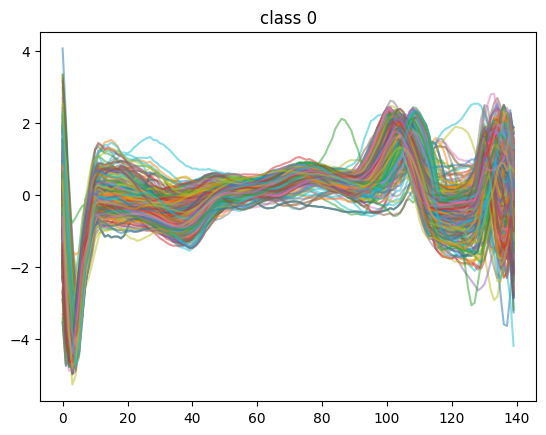

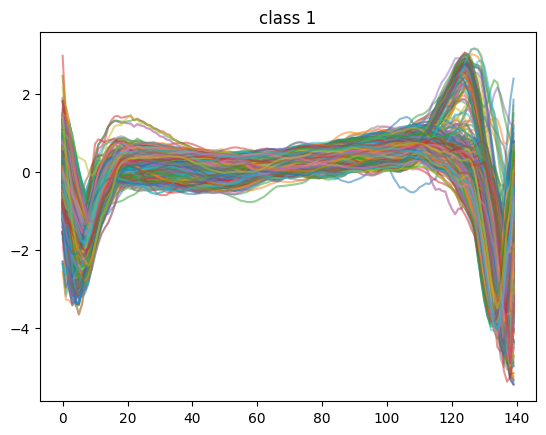

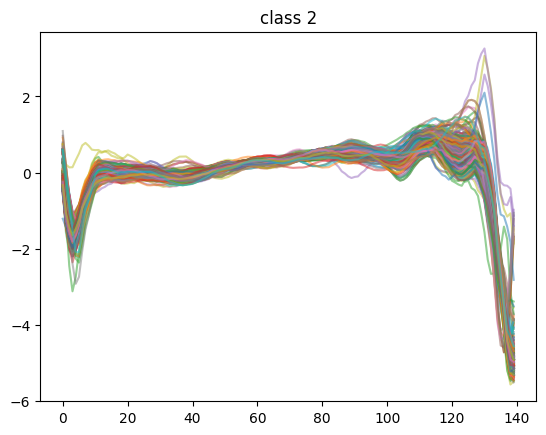

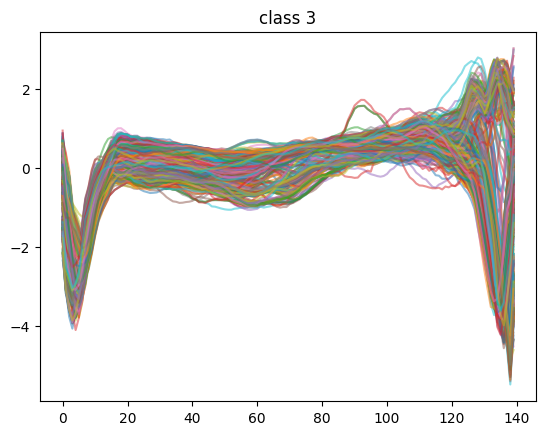

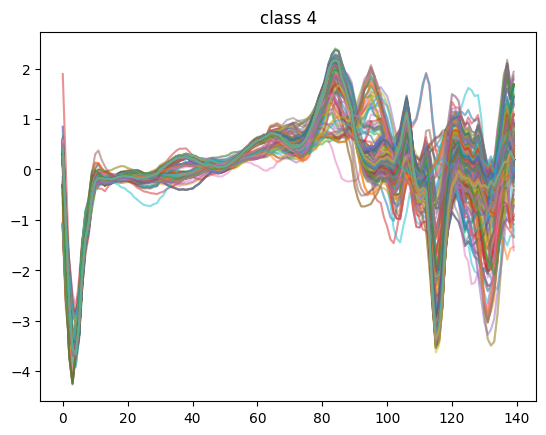

In [ ]:
for i in range(n_classes):
    plot_samples(x_gens[i], n_figs=1000, title="class {}".format(i))


In [ ]:
import torch


